# Finetune ResNet50

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

In [21]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


In [24]:
# Custom dataset class for loading Melspectrograms
class MelSpectrogramDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with Melspectrogram paths and labels.
            root_dir (string): Directory with all the Melspectrograms.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        df = pd.read_csv(csv_file)  # Read the CSV into a DataFrame
        # Sample only the given fraction of the dataset
        self.data_frame = df[['Melspectrogrampath', 'Emotion']]
        self.root_dir = root_dir
        self.transform = transform
        
        # Sort unique labels before mapping
        unique_labels = sorted(df['Emotion'].unique())  
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get the path to the Melspectrogram and the emotion label (string)
        # First column is path, second column is label (emotion as string)
        mel_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        emotion_label_str = self.data_frame.iloc[idx, 1]

        # Convert the emotion string to its corresponding integer
        emotion_label = self.label_map[emotion_label_str]

        # Load the Melspectrogram
        mel_image = Image.open(mel_path)
        mel_image = mel_image.convert("RGB")

        # Apply transformations if any
        if self.transform:
            mel_image = self.transform(mel_image)
            
        # Convert emotion label to tensor
        emotion_label = torch.tensor(emotion_label, dtype=torch.long)

        return mel_image, emotion_label

In [25]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    
    # train mode
    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update training loss
        train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100
    
    return model, train_loss, train_accuracy

In [26]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    
    # Switch to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Update test loss
            test_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100
    
    return test_loss, test_accuracy

In [27]:
def train_epochs(model, trainloader, testloader, labelmap, criterion, optimizer, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy}')
        print()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Save state every 5 epochs
        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f'resnet50_{epoch+1}.pth')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
                'labels': labelmap
            }
            torch.save(checkpoint, f'resnet50_variables_{epoch+1}.pth')
    
    return model, train_losses, train_accuracies, test_losses, test_accuracies

In [28]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [29]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model is on: cuda:0
Epoch 1/20
Train Loss: 1.4018215731729435 - Train Accuracy: 45.30560557193454
Test Loss: 1.304891617611201 - Test Accuracy: 49.63197467352592

Epoch 2/20
Train Loss: 1.2606700028045268 - Train Accuracy: 50.94877223530343
Test Loss: 1.2388259208563603 - Test Accuracy: 51.49188761377127

Epoch 3/20
Train Loss: 1.2289433648314656 - Train Accuracy: 51.815429668177046
Test Loss: 1.2419490910539723 - Test Accuracy: 51.6818361693708

Epoch 4/20
Train Loss: 1.2022508581982383 - Train Accuracy: 53.305368131541975
Test Loss: 1.2585010805515329 - Test Accuracy: 50.41551246537396

Epoch 5/20
Train Loss: 1.1854499930067908 - Train Accuracy: 54.04736935831734
Test Loss: 1.2156542924919513 - Test Accuracy: 52.62366442421844

Epoch 6/20
Train Loss: 1.1703401256211197 - Train Accuracy: 54.54995152258652
Test Loss: 1.192934513092041 - Test Accuracy: 53.95330431341512

Epoch 7/20
Train Loss: 1.1629626311833345 - Train Accuracy: 55.07825639605058
Test Loss: 1.201519787913621 - Test Acc

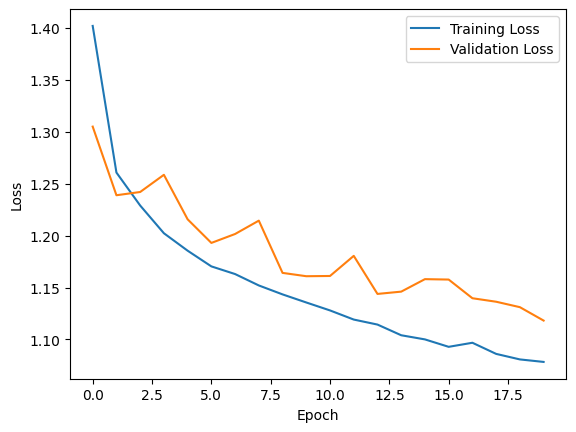

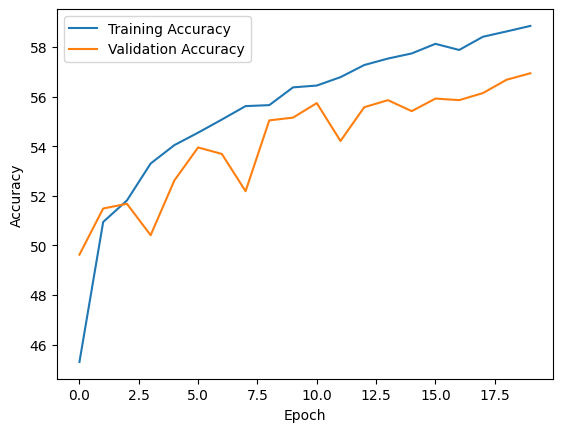

In [30]:
# Set random seed for reproducability
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Number of classes
num_classes = 9

# Import ResNet50 model
model = models.resnet50(pretrained=True)
# print("Original model")
# print(model)

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the Mel spectrogram to 448x448
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Load dataset
train_csv = '../data/melspectrogram_train_dataset.csv'
test_csv = '../data/melspectrogram_test_dataset.csv'
root_dir = '../data/'

trainset = MelSpectrogramDataset(csv_file=train_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# Label mappings
labelmap = trainset.label_map

# 60 epochs, save model every 5 epochs
epochs = 20
save_interval = 5
print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(model, trainloader, testloader, labelmap, criterion, optimizer, device, epochs, save_interval)
torch.save(model.state_dict(), f'resnet50_variables_{epochs}.pth')

# Plots
plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)


In [31]:
model.load_state_dict(torch.load('resnet50_20.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)
    
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
    
print(total) 
accuracy = correct/total
print(f"Test Accuracy: {accuracy:.2f}")

C:\Users\profi\AppData\Local\Temp\ipykernel_10904\1316275390.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_20.pth'))


12635
Test Accuracy: 0.57


In [32]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
model.eval()

correct = 0
total = 0

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)
    
    correct += (predicted == labels).sum().item()
    total += labels.size(0)
    
print(total) 
accuracy = correct/total
print(f"Test Accuracy: {accuracy:.2f}")

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda
12635
Test Accuracy: 0.13
